In [1]:
!pip install onnx
!pip install onnx2keras
!pip install onnxruntime

  Using cached onnx2keras-0.0.24.tar.gz (20 kB)
  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl (1.9 kB)


ERROR: Could not find a version that satisfies the requirement tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow->onnx2keras) (from versions: 0.0.1, 2.10.0.dev20220728, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow->onnx2keras)


In [2]:
#torchvision used
!pip install torchvision
import torchvision
from torchvision import transforms

tasks=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

In [3]:
from torchvision.datasets import MNIST
mnist=MNIST("data",download=True,train=True,transform=tasks)

In [4]:
from torch.utils.data import DataLoader
raw=DataLoader(mnist,batch_size=10)
dataiter=iter(raw)
data,labels=next(dataiter)
data=data.view(data.shape[0],-1)
print("shape",data.shape)

shape torch.Size([10, 784])


In [5]:
data[0][:400]

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

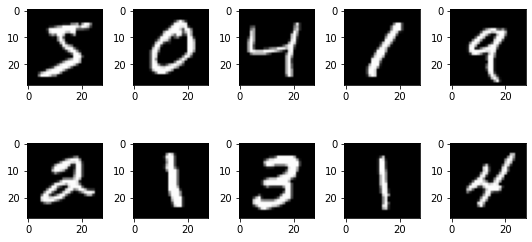

In [6]:
import matplotlib.pyplot as plt

num=10
num_row=2
num_col=5

fig,axes=plt.subplots(num_row,num_col,figsize=(1.5*num_col,2*num_row))

for i in range(num):
    ax=axes[i//num_col,i%num_col]
    pixels=data[i].numpy()
    pizels=pixels.reshape((28,28))
    ax.imshow(pizels,cmap='gray')
plt.tight_layout()
plt.show()





In [7]:
#pytorch training

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

## create training and validation split 
split = int(0.8 * len(mnist))
index_list = list(range(len(mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)
## create iterator objects for train and valid datasets
trainloader = DataLoader(mnist, sampler=tr_sampler)
validloader = DataLoader(mnist, sampler=val_sampler)


In [8]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
## create training and validation split 
split = int(0.8 * len(mnist))
index_list = list(range(len(mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)
## create iterator objects for train and valid datasets
trainloader = DataLoader(mnist, batch_size=32, sampler=tr_sampler)
validloader = DataLoader(mnist, batch_size=32, sampler=val_sampler)

In [9]:
import torch.nn.functional as F
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden=nn.Linear(784,32)
        self.output=nn.Linear(32,10)
    
    def forward(self,x):
        x=self.hidden(x)
        x=F.sigmoid(x)
        x=self.output(x)
        return x
##Essentially there will be 10 outputs for 10 digits and we are sigmoiding the output to get
##each letter probability when calling sigmoid here at the end
model=Model()

In [10]:
from torch import optim
import numpy as np

loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-6,momentum=0.9,nesterov=True)

In [11]:
count=0
for epoch in range(1,11):
    train_loss,valid_loss=[],[]
    model.train()
    for data,target in trainloader:
        optimizer.zero_grad()
        data=data.view(data.shape[0],-1)
       #print(data.shape)
        output=model(data)
        loss=loss_function(output,target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
    model.eval()
    for data,targer in validloader:
        count+=1
        data=data.view(data.shape[0],-1)
        output=model(data)
        loss=loss_function(output,target)
        valid_loss.append(loss.item())
    print("Epoch: ",epoch,"Training Loss: ",np.mean(train_loss),"Valid Loss: ",np.mean(valid_loss))
    

Epoch:  1 Training Loss:  0.598781957556804 Valid Loss:  5.722141811370849
Epoch:  2 Training Loss:  0.2899425372282664 Valid Loss:  6.239007006327311
Epoch:  3 Training Loss:  0.2409774563573301 Valid Loss:  7.173585951487223
Epoch:  4 Training Loss:  0.21181010472774506 Valid Loss:  7.224238731384277
Epoch:  5 Training Loss:  0.19144626914709806 Valid Loss:  7.482048603057861
Epoch:  6 Training Loss:  0.17527071384092172 Valid Loss:  7.603489735921224
Epoch:  7 Training Loss:  0.1628170476804177 Valid Loss:  7.734685241699219
Epoch:  8 Training Loss:  0.15294221393764018 Valid Loss:  8.083302008310953
Epoch:  9 Training Loss:  0.14515787963755428 Valid Loss:  8.04821766535441
Epoch:  10 Training Loss:  0.1368687976008902 Valid Loss:  8.31666902033488


In [12]:
import torch
dataiter=iter(validloader)
data,labels= next(dataiter)
data=data.view(data.shape[0],-1)
output=model(data)

_,preds_tensor=torch.max(output,1)
pytorchPred=np.squeeze(preds_tensor.numpy())

In [16]:
##pytorch to ONNX

x=torch.randn(1,1,32,784,requires_grad=True)
torch.onnx.export(model,x,"torchtoONNX.onnx",verbose=True,
input_names=['input'],output_names=['output'])

In [15]:
cd C:\Users\ganes\Desktop\DL\Colab

C:\Users\ganes\Desktop\DL\Colab


In [17]:
ls

 Volume in drive C is OS
 Volume Serial Number is 505D-495E

 Directory of C:\Users\ganes\Desktop\DL\Colab

06-04-2024  04:59 AM    <DIR>          .
30-03-2024  07:05 PM    <DIR>          ..
06-04-2024  04:59 AM    <DIR>          data
06-04-2024  03:49 AM           257,468 Knowledge_distillation - Colaboratory.pdf
30-03-2024  07:06 PM            13,617 Knowledge_distillation.ipynb
06-04-2024  05:15 AM           120,783 torchtoONNX.onnx
               3 File(s)        391,868 bytes
               3 Dir(s)  87,929,745,408 bytes free


In [20]:
import onnxruntime as rt
import numpy

sess=rt.InferenceSession("torchtoONNX.onnx")
input_name=sess.get_inputs()[0].name
#torch.onnx.export()
onnxPreds=sess.run(None,{input_name:
                        data.numpy().reshape(1,1,32,784)})[0]

In [21]:
import onnx

import onnx2keras
onnx_model=onnx.load("torchtoONNX.onnx")
k_model=onnx2keras.onnx_to_keras(onnx_model,['input'])

ModuleNotFoundError: No module named 'onnx2keras'

In [93]:
!pip install --upgrade onnx2keras

  Using cached onnx2keras-0.0.24.tar.gz (20 kB)
  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl (1.9 kB)


ERROR: Could not find a version that satisfies the requirement tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow->onnx2keras) (from versions: 0.0.1, 2.10.0.dev20220728, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow->onnx2keras)


SyntaxError: invalid syntax (<ipython-input-95-3105c1bc4374>, line 1)